In [1]:
import pandas as pd
df=pd.read_csv("wine.csv")
df

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


For convenience, I did some data cleaning on Excel already. The first column "Class" is the target variables. All predictor variables are numeric variables. 

In [2]:
from sklearn import preprocessing

X=df.drop(["Class"],axis=1)
names=X.columns
scaler=preprocessing.StandardScaler()
X=scaler.fit_transform(X)
X=pd.DataFrame(X,columns=names)
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315_of_diluted_wines,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


Feature selection.

In [3]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

y=df[["Class"]]

test=SelectKBest(score_func=mutual_info_classif,k="all")
fit=test.fit(X,y)
features=fit.transform(X)
set_printoptions(precision=3)

scores=fit.scores_
scores=pd.DataFrame(scores)
scores=scores.rename(columns={0:"scores"})
scores.sort_values(by=["scores"],ascending=False).nlargest(15,"scores")

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,scores
6,0.660724
12,0.574891
9,0.564978
11,0.521731
0,0.466708
10,0.445160
5,0.406394
1,0.284927
8,0.275077
3,0.250178


All features have non-zero feature importance scores. I am just going to use all of them.

One-hot encode the target variable.

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown="ignore")
y=enc.fit_transform(y)
y=pd.DataFrame(y.toarray())
y.head()

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


Split the data into train and test subsets.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=12)
print(X_train.shape)
print(X_test.shape)

(160, 13)
(18, 13)


In [6]:
length=X_train.shape[1]
num_classes=y_test.shape[1]

import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense

# define classification model

def classification_model():
    # create model
    model = Sequential()
    model.add(Dense(length, activation='relu', input_shape=(length,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50,activation="relu"))
    model.add(Dense(50,activation="relu"))
    model.add(Dense(50,activation="tanh"))
    model.add(Dense(num_classes, activation='softmax'))
      
    # compile model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Using TensorFlow backend.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/con

In [9]:
model=classification_model()
model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10, verbose=2)
model.evaluate(X_test,y_test,verbose=0)

Train on 160 samples, validate on 18 samples
Epoch 1/10
 - 1s - loss: 1.0723 - acc: 0.3500 - val_loss: 1.0326 - val_acc: 0.3889
Epoch 2/10
 - 0s - loss: 0.9456 - acc: 0.5375 - val_loss: 0.9327 - val_acc: 0.4444
Epoch 3/10
 - 0s - loss: 0.8211 - acc: 0.6875 - val_loss: 0.8254 - val_acc: 0.5556
Epoch 4/10
 - 0s - loss: 0.7106 - acc: 0.7125 - val_loss: 0.7144 - val_acc: 0.5556
Epoch 5/10
 - 0s - loss: 0.6040 - acc: 0.7562 - val_loss: 0.5985 - val_acc: 0.6667
Epoch 6/10
 - 0s - loss: 0.5071 - acc: 0.8500 - val_loss: 0.4831 - val_acc: 0.9444
Epoch 7/10
 - 0s - loss: 0.4184 - acc: 0.9125 - val_loss: 0.3813 - val_acc: 1.0000
Epoch 8/10
 - 0s - loss: 0.3378 - acc: 0.9125 - val_loss: 0.2863 - val_acc: 1.0000
Epoch 9/10
 - 0s - loss: 0.2663 - acc: 0.9125 - val_loss: 0.2067 - val_acc: 1.0000
Epoch 10/10
 - 0s - loss: 0.2056 - acc: 0.9250 - val_loss: 0.1429 - val_acc: 1.0000


[0.14293025434017181, 1.0]

100% accuracy on test data. This data set is just too easy to model.

Let's also explore how different classes of wine compare on the chemicals.

In [14]:
df_3=df[df["Class"]==3]
mean_3=df_3.mean()

df_2=df[df["Class"]==2]
mean_2=df_2.mean()

df_1=df[df["Class"]==1]
mean_1=df_1.mean()

mean=pd.concat([mean_1,mean_2,mean_3],axis=1).drop(["Class"],axis=0).T
mean

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315_of_diluted_wines,Proline
0,13.744746,2.010678,2.455593,17.037288,106.338983,2.840169,2.982373,0.290000,1.899322,5.528305,1.062034,3.157797,1115.711864
1,12.278732,1.932676,2.244789,20.238028,94.549296,2.258873,2.080845,0.363662,1.630282,3.086620,1.056282,2.785352,519.507042
2,13.153750,3.333750,2.437083,21.416667,99.312500,1.678750,0.781458,0.447500,1.153542,7.396250,0.682708,1.683542,629.895833


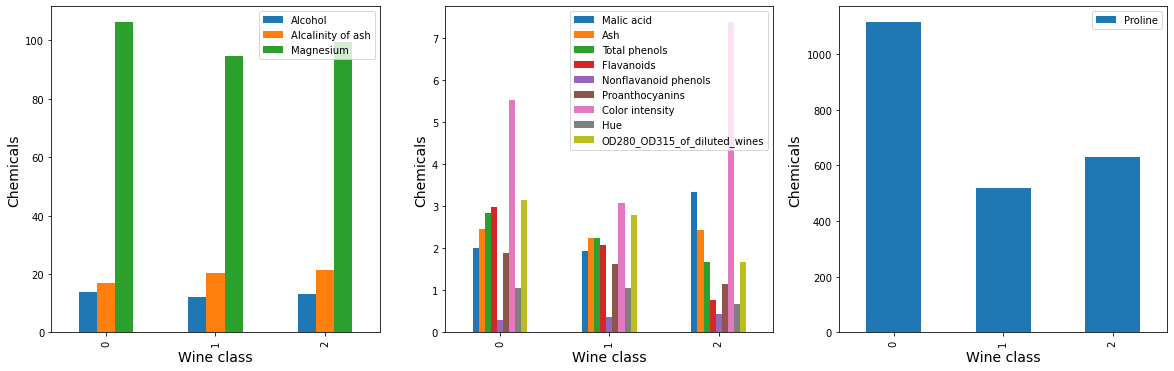

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). 
ax2 = fig.add_subplot(1,3,3)

mean[["Alcohol","Alcalinity of ash","Magnesium"]].plot(kind='bar',figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_xlabel("Wine class",fontsize=14)
ax0.set_ylabel('Chemicals',fontsize=14)

mean[["Malic acid","Ash","Total phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280_OD315_of_diluted_wines"]].plot(kind="bar",figsize=(20,6),ax=ax1)
ax1.set_xlabel("Wine class",fontsize=14)
ax1.set_ylabel("Chemicals",fontsize=14)

mean[["Proline"]].plot(kind="bar",figsize=(20,6),ax=ax2)
ax2.set_xlabel("Wine class",fontsize=14)
ax2.set_ylabel("Chemicals",fontsize=14)


plt.show()